In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from tqdm import tqdm
import re
import time
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix


In [4]:
dataset = pd.read_csv('/content/drive/MyDrive/NLP/train_data/train.csv', delimiter=',')
dataset.head()

,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2
1,2,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1
2,3,How many men does it take to open a can of bee...,1,1.95,0.0,2.4
3,4,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0
4,5,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1


In [5]:
test_data=pd.read_csv('/content/drive/MyDrive/NLP/public_test.csv', delimiter=',')
test_data.head()

,id,text
0,9001,Finding out your ex got fat is like finding 20...
1,9002,"For Brockmann, stereotypes imperil national se..."
2,9003,A girl runs up to her mother with a pile of cr...
3,9004,gotta wonder if baseball still would've been c...
4,9005,When you're dreading getting in the shower cuz...


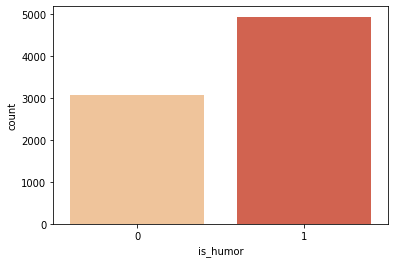

In [5]:
#Distribution of humor_controversy values
sns.countplot(x='is_humor',data=dataset, palette="OrRd")

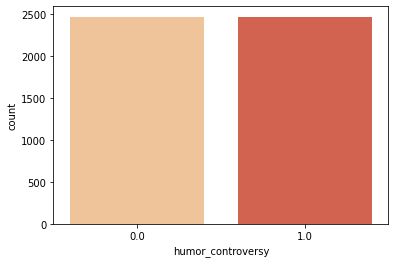

In [6]:
#Distribution of humor_controversy values
sns.countplot(x='humor_controversy',data=dataset, palette="OrRd")

In [7]:
print(dataset.humor_controversy.value_counts())
dataset.humor_controversy.fillna(0,inplace=True)

0.0    2467
1.0    2465
Name: humor_controversy, dtype: int64


In [8]:
dataset.humor_controversy.value_counts()

0.0    5535
1.0    2465
Name: humor_controversy, dtype: int64

In [10]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();

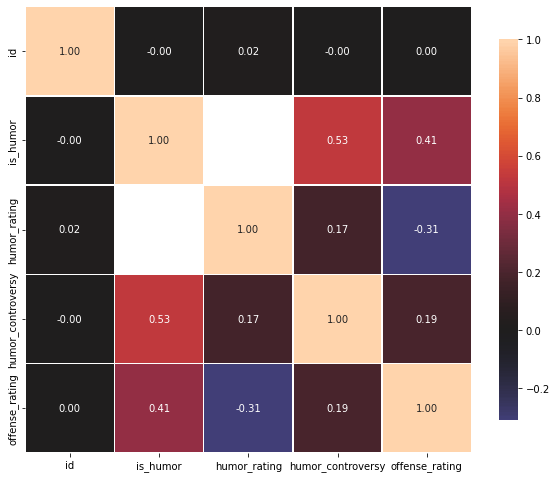

In [11]:
correlation_heatmap(dataset)

In [6]:
train=dataset.drop(['id','humor_rating','humor_controversy','offense_rating'],axis=1)
train.shape

(8000, 2)

In [7]:
test=test_data.drop(['id'],axis=1)
test.shape

(1000, 1)

In [11]:
train['clean_text'] = train['text'].apply(lambda x: re.sub(r'http\S+', '', x))
test['clean_text'] = test['text'].apply(lambda x: re.sub(r'http\S+', '', x))
# remove punctuation marks
punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'

train['clean_text'] = train['clean_text'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))
test['clean_text'] = test['clean_text'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))

# convert text to lowercase
train['clean_text'] = train['clean_text'].str.lower()
test['clean_text'] = test['clean_text'].str.lower()

# remove numbers
train['clean_text'] = train['clean_text'].str.replace("[0-9]", " ")
test['clean_text'] = test['clean_text'].str.replace("[0-9]", " ")

# remove whitespaces
train['clean_text'] = train['clean_text'].apply(lambda x:' '.join(x.split()))
test['clean_text'] = test['clean_text'].apply(lambda x: ' '.join(x.split()))

# import spaCy's language model
nlp = spacy.load('en', disable=['parser', 'ner'])

# function to lemmatize text
def lemmatization(texts):
    output = []
    for i in texts:
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output


train['clean_text'] = lemmatization(train['clean_text'])
test['clean_text'] = lemmatization(test['clean_text'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  from ipykernel import kernelapp as app


In [19]:
train.head()

,text,is_humor,clean_text
0,TENNESSEE: We're the best state. Nobody even c...,1,tennessee -PRON- be the good state . nobody ev...
1,A man inserted an advertisement in the classif...,1,a man insert an advertisement in the classifie...
2,How many men does it take to open a can of bee...,1,how many man do -PRON- take to open a can of b...
3,Told my mom I hit 1200 Twitter followers. She ...,1,tell -PRON- mom i hit twitt follower . -PRON- ...
4,Roses are dead. Love is fake. Weddings are bas...,1,rose be dead . love be fake . wedding be basic...


In [20]:
test.head()

,text,clean_text
0,Finding out your ex got fat is like finding 20...,find out -PRON- ex get fat be like find buck i...
1,"For Brockmann, stereotypes imperil national se...","for brockmann , stereotype imperil national se..."
2,A girl runs up to her mother with a pile of cr...,a girl run up to -PRON- mother with a pile of ...
3,gotta wonder if baseball still would've been c...,get to wonder if baseball still would have be ...
4,When you're dreading getting in the shower cuz...,when -PRON- be dread get in the shower cuz -PR...


# Is_Humor

# ELMo

In [21]:
import tensorflow_hub as hub
import tensorflow as tf

elmo = hub.load("https://tfhub.dev/google/elmo/2")

In [22]:
x = ["Roasted ants are a popular snack in Columbia"]

# Extract ELMo features 
#embeddings = elmo(x, signature="default", as_dict=True)["elmo"]
embeddings = elmo.signatures["default"](tf.constant([
                "i like green eggs and ham",
                "i like green ham and eggs"
                ])
                )["elmo"]

embeddings.shape

TensorShape([2, 6, 1024])

In [26]:
print(embeddings)

tf.Tensor(
[[[-1.3958733  -0.47634843 -0.42686158 ... -0.44233415  0.36551476
   -0.09755356]
  [-0.01843544 -0.4835792  -0.51914    ... -0.7535665   0.18082426
    0.10429917]
  [-0.21240005 -0.54602915 -0.16077662 ...  0.17620865  0.01360187
    0.41795325]
  [-0.07890855  0.03399481  0.29570404 ...  0.14347464 -0.22136195
    0.37822232]
  [ 0.26714376  0.04983523  0.07959403 ... -0.30136648 -0.03871734
    0.7418539 ]
  [-0.26349774 -0.5577202   0.44527808 ...  0.31585708  0.06556918
    0.27271774]]

 [[-1.3958733  -0.47634843 -0.42686158 ... -0.44889075  0.45312923
   -0.19382511]
  [-0.01843544 -0.4835792  -0.51914    ... -0.76729137  0.19235286
    0.12666166]
  [-0.21240005 -0.54602915 -0.16077662 ...  0.3067825   0.18081887
    0.26859778]
  [-0.17135632 -0.3619399   0.46034896 ...  0.06333641  0.10532565
    0.54787606]
  [ 0.26280773 -0.20229791  0.05741575 ... -0.4762926  -0.13840881
    0.6447184 ]
  [-0.16827193 -0.3474773   0.19467454 ...  0.5863697   0.21405141
    0.1

In [23]:
def elmo_vectors(x):
  embeddings=elmo.signatures["default"](tf.constant(x.tolist()))["elmo"]
  return tf.reduce_mean(embeddings,1)

In [24]:
list_train = [train[i:i+100] for i in range(0,train.shape[0],100)]
list_test = [test[i:i+100] for i in range(0,test.shape[0],100)]
# Extract ELMo embeddings
elmo_train = [elmo_vectors(x['clean_text']) for x in list_train]
elmo_test = [elmo_vectors(x['clean_text']) for x in list_test]

In [40]:
elmo_train_new = np.concatenate(elmo_train, axis = 0)
elmo_test_new = np.concatenate(elmo_test, axis = 0)

In [41]:
# save elmo_train_new
pickle_out = open("/content/drive/MyDrive/NLP/elmo_train.pickle","wb")
pickle.dump(elmo_train_new, pickle_out)
pickle_out.close()

# save elmo_test_new
pickle_out = open("/content/drive/MyDrive/NLP/elmo_test.pickle","wb")
pickle.dump(elmo_test_new, pickle_out)
pickle_out.close()

In [30]:
# load elmo_train_new
pickle_in = open("/content/drive/MyDrive/NLP/elmo_train.pickle", "rb")
elmo_train_new = pickle.load(pickle_in)
# load elmo_test_new
pickle_in = open("/content/drive/MyDrive/NLP/elmo_test.pickle", "rb")
elmo_test_new = pickle.load(pickle_in)

In [5]:
len(elmo_train_new)

8000

In [9]:
X=elmo_train_new
y=dataset['is_humor']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)


In [56]:
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
#scorings=['accuracy','roc_auc','f1']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0,refit=False)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Best: %f using %s" % ( grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.893207 using {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.872699 (0.006808) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.874204 (0.006238) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.872737 (0.006921) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.889553 (0.005732) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.889382 (0.005882) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.889489 (0.005864) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.893124 (0.004921) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.893207 (0.004966) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.892974 (0.004797) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.873829 (0.006308) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.873829 (0.006308) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.873983 (0.006241) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.836214 (0.005460) with: {

In [10]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# define model and parameters
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.881250 using {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.873490 (0.006133) with: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
0.873958 (0.004907) with: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
0.664948 (0.005786) with: {'C': 50, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.876250 (0.007096) with: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.881250 (0.008103) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.665312 (0.005734) with: {'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.815469 (0.012066) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.870729 (0.007077) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.671927 (0.005707) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.726042 (0.005904) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.802187 (0.011439) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.735729 (0.013342) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.654896 (0.002412) with: {'C': 0.01, 'gamma': 'scale', 

In [59]:
# example of grid searching key hyperparameters for RandomForestClassifier

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# define models and parameters
model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.876465 using {'max_features': 'sqrt', 'n_estimators': 1000}
0.825308 (0.005464) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.871892 (0.003973) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.876465 (0.004755) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.818663 (0.005410) with: {'max_features': 'log2', 'n_estimators': 10}
0.868577 (0.006549) with: {'max_features': 'log2', 'n_estimators': 100}
0.873797 (0.005182) with: {'max_features': 'log2', 'n_estimators': 1000}


# BERT

In [3]:
import simpletransformers
from simpletransformers.language_representation import RepresentationModel
#sentences=["ml and dl","Ds in excel"]
model=RepresentationModel(
    model_type='bert',
    model_name='bert-base-uncased',
    use_cuda=False
)


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTextRepresentation: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTextRepresentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTextRepresentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [12]:
sentences=train['clean_text'].tolist()
print(len(sentences))

8000


In [13]:
sentence_vectors=model.encode_sentences(sentences,combine_strategy="mean")

In [15]:
sentences_test=test['clean_text'].tolist()
print(len(sentences_test))
sentence_vectors_test=model.encode_sentences(sentences_test,combine_strategy="mean")

1000


In [16]:
pickle_out = open("/content/drive/MyDrive/NLP/bertTrain.pickle","wb")
pickle.dump(sentence_vectors, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/MyDrive/NLP/bertTest.pickle","wb")
pickle.dump(sentence_vectors_test, pickle_out)
pickle_out.close()

In [31]:
pickle_in_bertTrain = open("/content/drive/MyDrive/NLP/bertTrain.pickle", "rb")
bert_train = pickle.load(pickle_in_bertTrain)

pickle_in_bertTest = open("/content/drive/MyDrive/NLP/bertTest.pickle", "rb")
bert_test = pickle.load(pickle_in_bertTest)

In [18]:
X=bert_train
y=dataset['is_humor']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)


In [19]:
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
#scorings=['accuracy','roc_auc','f1']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0,refit=False)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Best: %f using %s" % ( grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search fail

Best: 0.909807 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.881692 (0.001544) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.888808 (0.005347) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.882114 (0.001942) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.897152 (0.004245) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.897242 (0.004130) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.897276 (0.004273) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.909633 (0.003506) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.909547 (0.002957) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.909807 (0.003215) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.908058 (0.003261) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.907929 (0.003283) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.908082 (0.003277) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.894758 (0.001945) wit

In [20]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# define model and parameters
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.893125 using {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.889479 (0.004041) with: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
0.889167 (0.004900) with: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
0.786510 (0.004237) with: {'C': 50, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.893021 (0.005271) with: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.893125 (0.004467) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.801562 (0.003307) with: {'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.889896 (0.003647) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.888438 (0.005173) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.855208 (0.004152) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.869583 (0.003822) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.861719 (0.004840) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.813802 (0.005037) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.616563 (0.000000) with: {'C': 0.01, 'gamma': 'scale', 

# BERT and ELMo

In [32]:
elbe=np.zeros((8000,768+1024))
elbe[0:8000,0:768]=bert_train
elbe[0:8000,768:768+1024]=elmo_train_new

In [12]:
y=dataset['is_humor']
X_train, X_test, y_train, y_test = train_test_split(elbe,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)


In [13]:
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
#scorings=['accuracy','roc_auc','f1']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0,refit=False)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Best: %f using %s" % ( grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.912877 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.897747 (0.003966) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.898021 (0.005558) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.897692 (0.004042) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.902638 (0.003071) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.903286 (0.004047) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.902832 (0.003082) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.912862 (0.004343) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.912562 (0.004227) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.912877 (0.004554) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.912480 (0.004025) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.912547 (0.003771) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.912169 (0.004120) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.897233 (0.002150) wit

In [14]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# define model and parameters
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.900104 using {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.897448 (0.004350) with: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
0.896094 (0.004506) with: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
0.778802 (0.012603) with: {'C': 50, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.898958 (0.004057) with: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.900104 (0.003864) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.797656 (0.008563) with: {'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.895052 (0.003556) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.893437 (0.003719) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.841823 (0.004380) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.868906 (0.005676) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.862708 (0.006298) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.815104 (0.005607) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.617396 (0.000531) with: {'C': 0.01, 'gamma': 'scale', 

# Test DAta

In [33]:
testset = pd.read_csv('/content/drive/MyDrive/NLP/gold-test-27446.csv', delimiter=',')
testset.head()

,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,9001,Finding out your ex got fat is like finding 20...,1,2.20,0.0,0.90
1,9002,"For Brockmann, stereotypes imperil national se...",0,NaN,NaN,0.35
2,9003,A girl runs up to her mother with a pile of cr...,1,2.80,1.0,0.10
3,9004,gotta wonder if baseball still would've been c...,1,2.15,0.0,0.00
4,9005,When you're dreading getting in the shower cuz...,1,2.25,0.0,0.35


In [34]:
elbe_test=np.zeros((1000,768+1024))
elbe_test[0:1000,0:768]=bert_test
elbe_test[0:1000,768:768+1024]=elmo_test_new

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

lreg = LogisticRegression()
lreg.fit(elbe, y)
preds_valid = lreg.predict(elbe_test)
f1_score(testset['is_humor'], preds_valid)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.9095354523227384

In [25]:
submit=pd.DataFrame(testset['id'])
submit['is_humor']=preds_valid

In [27]:
submit.to_csv('/content/drive/MyDrive/NLP/submit1.csv')

# Humor_Controversy

In [28]:
elmo_bert=pd.DataFrame(elbe)
elmo_bert['is_humor']=dataset['is_humor']
elmo_bert['humor_controversy']=dataset['humor_controversy']
elmo_bert.head()

,0,1,2,3,4,5,6,7,8,9,...,1784,1785,1786,1787,1788,1789,1790,1791,is_humor,humor_controversy
0,-0.097147,-0.015473,0.481062,0.132561,0.126918,-0.172785,0.311292,0.419162,-0.041139,-0.185922,...,0.037709,0.077825,0.139237,0.041493,-0.011658,0.021222,0.162092,-0.007068,1,1.0
1,0.114320,0.143821,0.423334,0.020045,0.133565,0.143562,0.272166,0.319829,0.061305,-0.105126,...,0.090904,0.077136,0.051262,-0.032070,0.154468,-0.027841,-0.091965,0.008593,1,1.0
2,0.138741,0.244412,0.309515,-0.097398,0.098342,-0.032771,0.260337,0.145873,-0.171477,-0.191017,...,0.035934,0.039816,0.157507,0.032448,0.117436,0.035879,0.030508,0.104441,1,0.0
3,0.126801,-0.036132,0.641331,-0.159810,0.157103,-0.141970,0.426256,0.093160,-0.117746,0.034776,...,0.128024,0.103870,0.149682,-0.084154,0.220254,-0.141522,0.114892,-0.058903,1,1.0
4,0.238925,-0.355007,0.676536,0.072475,0.192187,-0.186207,0.364489,0.221788,0.358300,-0.147759,...,-0.006642,0.053187,0.134489,0.078815,0.022858,-0.051210,0.078954,0.043940,1,0.0


In [29]:
elmo_bert.to_csv('/content/drive/MyDrive/NLP/ELMo_BERT.csv')

In [22]:
df=pd.read_csv('/content/drive/MyDrive/NLP/ELMo_BERT.csv')

In [23]:
df.humor_controversy.value_counts()

0.0    2467
1.0    2465
Name: humor_controversy, dtype: int64

In [24]:
df.fillna(0,inplace=True)
df.humor_controversy.value_counts()

0.0    5535
1.0    2465
Name: humor_controversy, dtype: int64

In [38]:
X=df.drop(["humor_controversy","is_humor"],axis=1)
y=df["humor_controversy"]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

# Class Balancing

In [27]:
import collections as k
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
Xa, ya = smote.fit_resample(X_train, y_train)

print('Original dataset shape', k.Counter(y_train))
print('Resample dataset shape', k.Counter(ya))

Original dataset shape Counter({0.0: 4428, 1.0: 1972})
Resample dataset shape Counter({0.0: 4428, 1.0: 4428})


In [28]:
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
#scorings=['accuracy','roc_auc','f1']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0,refit=False)
grid_result = grid_search.fit(Xa, ya)
# summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Best: %f using %s" % ( grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.814944 using {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.795203 (0.004721) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.787107 (0.006388) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.795149 (0.004441) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.796272 (0.003444) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.786847 (0.010351) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.795672 (0.004040) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.803116 (0.002019) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.790811 (0.005593) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.802327 (0.002092) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.814944 (0.002936) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.792204 (0.005776) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.814523 (0.002566) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.807915 (0.001991) wit

In [36]:
testset.fillna(0,inplace=True)
testset.humor_controversy.value_counts()

0.0    721
1.0    279
Name: humor_controversy, dtype: int64

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

lreg = LogisticRegression(solver='newton-cg', class_weight='balanced')
lreg.fit(X.drop(["Unnamed: 0"],axis=1), y)
preds_valid = lreg.predict(elbe_test)
f1_score(testset['humor_controversy'], preds_valid)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


0.5251076040172167

In [46]:
submit2=pd.DataFrame(testset['id'])
submit2['humor_controversy']=preds_valid
submit2.to_csv('/content/drive/MyDrive/NLP/submit2.csv')